### **Flower Classification**

In [2]:
# Loading Libraires
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.autograd import Variable
from torchvision import models
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset,DataLoader

In [3]:
is_cuda = False
if torch.cuda.is_available():
    is_cuda = True

In [4]:
simple_transform = transforms.Compose([transforms.Resize((120,120))
                                       ,transforms.ToTensor()
                                      ])
dataset = ImageFolder('/content/drive/MyDrive/flower_photos',simple_transform)
print(len(dataset), len(dataset.classes))

3670 5


In [5]:
#Loader
data_loader = DataLoader(dataset,batch_size=16,num_workers=3,shuffle=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [6]:
#Function to get Mean and std of dataset
def get_mean_std(loader):
    #VAR[X] = E[X**2] - E[X] **2
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    
    for data, _ in loader:
        channels_sum +=torch.mean(data, dim=[0,2,3]) #BxCxHxW 
        channels_squared_sum+=torch.mean(data**2, dim=[0,2,3])
        num_batches +=1
        
    mean = channels_sum/num_batches
    std = (channels_squared_sum/num_batches -mean**2)**0.5
    
    return mean, std

In [7]:
mean, std = get_mean_std(data_loader)
print(mean)
print(std)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


tensor([0.4664, 0.4251, 0.3039])
tensor([0.2910, 0.2614, 0.2860])


In [8]:
simple_transform = transforms.Compose([transforms.Resize((120,120))
                                       ,transforms.ToTensor()
                                      ])
dataset = ImageFolder('/content/drive/MyDrive/flower_photos',simple_transform)
print(len(dataset), len(dataset.classes))

3670 5


In [9]:
#Spliting the dataset into training and testing
train, val = torch.utils.data.random_split(dataset, [2600,1070])

In [10]:
#DataLoader
train_data_loader = DataLoader(train,batch_size=16,num_workers=3,shuffle=True)
test_data_loader = DataLoader(val,batch_size=16,num_workers=3,shuffle=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [11]:
#Function to Display Image
def imshow(inp,cmap=None):
    inp = inp.numpy().transpose((1, 2, 0)) # Changing into HxWxC in numpy
    print(inp.shape)
    mean = np.array([0.4591, 0.4201, 0.3004])
    std = np.array([0.2890, 0.2584, 0.2817])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp,cmap)

(120, 120, 3)


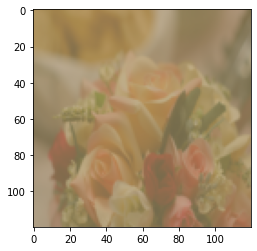

In [12]:
imshow(train[75][0])

### **Custom CNN**

In [38]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
    
            
        self.fc1 = nn.Linear(7*7*256, 128)
        self.fc2 = nn.Linear(128, 5)   
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc1(out)
        out = F.dropout(out, training=self.training)
        out = self.fc2(out)
        return F.log_softmax(out,dim=1)

In [39]:
model = Net()
if is_cuda:
    model.cuda()

In [40]:
# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [41]:
def fit(epoch,model,data_loader,phase='training',volatile=False):
    if phase == 'training':
        model.train()
    if phase == 'validation':
        model.eval()
        volatile=True
    running_loss = 0.0
    running_correct = 0
    for batch_idx , (data,target) in enumerate(data_loader):
        if is_cuda:
            data,target = data.cuda(),target.cuda()
        data , target = Variable(data,volatile),Variable(target)
        if phase == 'training':
            optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output,target)
        
        running_loss += F.nll_loss(output,target,size_average=False).item()
        preds = output.data.max(dim=1,keepdim=True)[1]
        running_correct += preds.eq(target.data.view_as(preds)).cpu().sum()
        if phase == 'training':
            loss.backward()
            optimizer.step()
    
    loss = running_loss/len(data_loader.dataset)
    accuracy = 100. * running_correct/len(data_loader.dataset)
    
    print(f'{phase} loss is {loss:{5}.{2}} and {phase} accuracy is {running_correct}/{len(data_loader.dataset)}{accuracy:{10}.{4}}')
    return loss,accuracy

In [42]:
train_losses , train_accuracy = [],[]
val_losses , val_accuracy = [],[]
for epoch in range(1,20):
    epoch_loss, epoch_accuracy = fit(epoch,model,train_data_loader,phase='training')
    val_epoch_loss , val_epoch_accuracy = fit(epoch,model,test_data_loader,phase='validation')
    train_losses.append(epoch_loss)
    train_accuracy.append(epoch_accuracy)
    val_losses.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


training loss is   3.9 and training accuracy is 900/2600     34.62
validation loss is   1.5 and validation accuracy is 502/1070     46.92
training loss is   1.5 and training accuracy is 1225/2600     47.12
validation loss is   1.2 and validation accuracy is 579/1070     54.11
training loss is   1.2 and training accuracy is 1363/2600     52.42
validation loss is   1.0 and validation accuracy is 603/1070     56.36
training loss is   1.1 and training accuracy is 1506/2600     57.92
validation loss is  0.95 and validation accuracy is 697/1070     65.14
training loss is  0.95 and training accuracy is 1643/2600     63.19
validation loss is   1.0 and validation accuracy is 662/1070     61.87
training loss is  0.93 and training accuracy is 1674/2600     64.38
validation loss is   1.1 and validation accuracy is 612/1070      57.2
training loss is  0.84 and training accuracy is 1749/2600     67.27
validation loss is  0.83 and validation accuracy is 743/1070     69.44
training loss is   0.8 and t

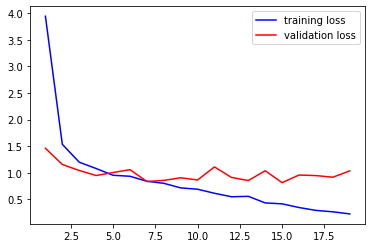

In [43]:
#Loss 
plt.plot(range(1,len(train_losses)+1),train_losses,'b',label = 'training loss')
plt.plot(range(1,len(val_losses)+1),val_losses,'r',label = 'validation loss')
plt.legend()

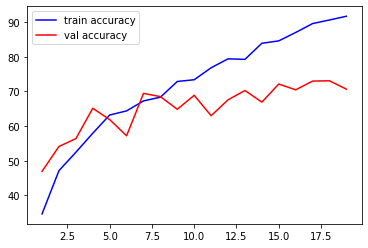

In [44]:
#Accuracy
plt.plot(range(1,len(train_accuracy)+1),train_accuracy,'b',label = 'train accuracy')
plt.plot(range(1,len(val_accuracy)+1),val_accuracy,'r',label = 'val accuracy')
plt.legend()

### **Changing the Learning Rate**

In [45]:
model = Net()
if is_cuda:
    model.cuda()

In [46]:
# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [47]:
train_losses , train_accuracy = [],[]
val_losses , val_accuracy = [],[]
for epoch in range(1,20):
    epoch_loss, epoch_accuracy = fit(epoch,model,train_data_loader,phase='training')
    val_epoch_loss , val_epoch_accuracy = fit(epoch,model,test_data_loader,phase='validation')
    train_losses.append(epoch_loss)
    train_accuracy.append(epoch_accuracy)
    val_losses.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


training loss is 1.4e+01 and training accuracy is 772/2600     29.69
validation loss is   1.3 and validation accuracy is 492/1070     45.98
training loss is   1.3 and training accuracy is 1189/2600     45.73
validation loss is   1.3 and validation accuracy is 531/1070     49.63
training loss is   1.2 and training accuracy is 1319/2600     50.73
validation loss is   1.2 and validation accuracy is 552/1070     51.59
training loss is   1.2 and training accuracy is 1391/2600      53.5
validation loss is   1.2 and validation accuracy is 569/1070     53.18
training loss is   1.1 and training accuracy is 1443/2600      55.5
validation loss is   1.1 and validation accuracy is 605/1070     56.54
training loss is   1.1 and training accuracy is 1501/2600     57.73
validation loss is   1.2 and validation accuracy is 593/1070     55.42
training loss is   1.0 and training accuracy is 1517/2600     58.35
validation loss is   1.3 and validation accuracy is 574/1070     53.64
training loss is   1.0 and

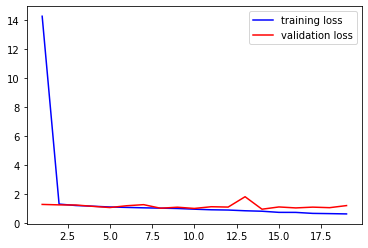

In [48]:
#Loss 
plt.plot(range(1,len(train_losses)+1),train_losses,'b',label = 'training loss')
plt.plot(range(1,len(val_losses)+1),val_losses,'r',label = 'validation loss')
plt.legend()

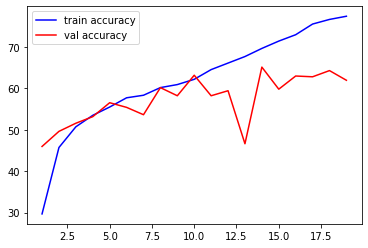

In [49]:
#Accuracy
plt.plot(range(1,len(train_accuracy)+1),train_accuracy,'b',label = 'train accuracy')
plt.plot(range(1,len(val_accuracy)+1),val_accuracy,'r',label = 'val accuracy')
plt.legend()